# Ransomware Detection Using Machine Learning

### Introduction

#### Business Problem & Objective:

With the prevalence of ransomware attacks causing both data and financial loss to companies, we can further mitigate ransomware attacks by applying machine learning techniques in ransomware detection, which have the potential to detect ransomware more accurately compared to conventional methods.  

#### Data Mining Objective:

To classify whether the family of the file is a goodware, encryptor ransomware or locker ransomware.

#### Class Details:
    
- G - Goodware

- E - Encryptor

- L - Locker

The following code has gone through many iterations. Latest run may not reflect results obtained prior to reporting.

### 1) Import relevant libraries

In [ ]:
pip install memory_profiler

In [ ]:
# for data manipulation
import pandas as pd
import numpy as np

# for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# for modelling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score,mean_squared_error, r2_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# miscellaneous
import time
from google.colab import files
from urllib.error import HTTPError
import re
from memory_profiler import profile
import memory_profiler

import warnings
warnings.filterwarnings('ignore')


### 2) Exploratory Data Analysis

In [ ]:
# read file obtained via url
try:
  url = 'https://raw.githubusercontent.com/Juan-Herrera-Silva/Paper-SENSORS/main/Annex%20A%20-%20Dataset%20with%2050%20chosen%20features.csv'
  df = pd.read_csv(url)
# upload file option
except HTTPError:
  print("Invalid link. Please check your link or upload the dataset manually")
  uploaded_file = files.upload()
  filename = next(iter(uploaded_file))
  df = pd.read_csv(f'/content/{filename}')

In [ ]:
# get 10 samples of the dataset
df.sample(10)

,family,proc_pid,file,urls,type,name,ext_urls,path,program,info,...,regkey_opened,file_created,wmi_query,dll_loaded,regkey_written,file_read,apistats,errors,action,log
682,E,8,8,19,0,0,0,0,1,1,...,516,381,0,15,12,2939,298,0,0,0
1898,G,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,14
1014,L,0,0,0,0,0,0,0,1,1,...,8,1,0,15,1,0,138,0,1,2083
843,G,0,0,0,0,0,0,0,0,0,...,0,10,0,16,0,15,57,0,1,28
521,E,1,1,2,1,1,0,1,0,0,...,75,0,0,4,0,0,23,0,1,39
1238,E,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,13,0,1,19
1542,E,0,0,0,0,0,0,0,0,0,...,0,0,0,26,4,12,58,0,1,22
77,E,4,4,12,2,2,0,2,1,1,...,17,1,1,12,3,2,126,0,1,40
1983,L,2,2,0,3,3,0,3,0,0,...,0,0,0,0,0,0,14,0,1,22
1555,L,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,19,0,1,19


In [ ]:
# number of rows, columns
df.shape

(2000, 51)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 51 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   family                2000 non-null   object
 1   proc_pid              2000 non-null   int64 
 2   file                  2000 non-null   int64 
 3   urls                  2000 non-null   int64 
 4   type                  2000 non-null   int64 
 5   name                  2000 non-null   int64 
 6   ext_urls              2000 non-null   int64 
 7   path                  2000 non-null   int64 
 8   program               2000 non-null   int64 
 9   info                  2000 non-null   int64 
 10  positives             2000 non-null   int64 
 11  families              2000 non-null   int64 
 12  description           2000 non-null   int64 
 13  sign_name             2000 non-null   int64 
 14  sign_stacktrace       2000 non-null   int64 
 15  arguments             2000 non-null   

In [ ]:
# number of missing values
df.isnull().sum()

family                  0
proc_pid                0
file                    0
urls                    0
type                    0
name                    0
ext_urls                0
path                    0
program                 0
info                    0
positives               0
families                0
description             0
sign_name               0
sign_stacktrace         0
arguments               0
api                     0
category                0
imported_dll_count      0
dll                     0
pe_res_name             0
filetype                0
pe_sec_name             0
entropy                 0
hosts                   0
requests                0
mitm                    0
domains                 0
dns_servers             0
tcp                     0
udp                     0
dead_hosts              0
proc                    0
beh_command_line        0
process_path            0
tree_command_line       0
children                0
tree_process_name       0
command_line

In [ ]:
# number of outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

action                  332
api                     247
apistats                261
arguments               247
beh_command_line        384
category                247
children                 69
command_line            257
dead_hosts               59
description              63
directory_enumerated    439
dll                     100
dll_loaded              112
dns_servers               0
domains                   0
entropy                   0
errors                    8
ext_urls                  0
families                261
family                    0
file                    432
file_created            375
file_read               344
filetype                200
hosts                    50
imported_dll_count        0
info                    141
log                     448
mitm                      0
name                    278
path                    278
pe_res_name             200
pe_sec_name               0
positives                90
proc                    384
proc_pid            

In [ ]:
# columns with only 1 unique value
df.loc[:, df.nunique() == 1].nunique()

ext_urls              1
sign_stacktrace       1
imported_dll_count    1
mitm                  1
dtype: int64

In [ ]:
# number of samples in a given class
df['family'].value_counts()

G    1000
E     800
L     200
Name: family, dtype: int64

Ransomware and Goodware classes are balanced (1000 each) hence there is no need for balancing methods such as oversampling or undersampling.

### 3) Data Preparation

In [ ]:
# renaming classes
df['family'].replace({'G': 'Goodware', 'E': 'Encryptor Ransomware', 'L': 'Locker Ransomware'}, inplace=True)
df.sample(10)

,family,proc_pid,file,urls,type,name,ext_urls,path,program,info,...,regkey_opened,file_created,wmi_query,dll_loaded,regkey_written,file_read,apistats,errors,action,log
791,Encryptor Ransomware,4,4,26,0,0,0,0,0,0,...,152,2110,2,38,36,1963,282,0,1,2194
787,Encryptor Ransomware,0,0,0,0,0,0,0,0,0,...,5,89,0,17,8,745,61,0,1,805
262,Encryptor Ransomware,0,0,0,0,0,0,0,0,0,...,58,802,0,19,7,9292,73,0,1,13991
1157,Goodware,0,0,0,0,0,0,0,0,0,...,8,0,0,3,0,1,35,0,1,18
938,Goodware,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,19,0,1,18
237,Encryptor Ransomware,0,0,0,0,0,0,0,0,0,...,4,2140,0,8,2,2165,91,0,1,2206
1371,Encryptor Ransomware,3,3,390,0,0,0,0,0,0,...,23,26,1,81,20,56,350,0,1,130
139,Goodware,0,0,0,0,0,0,0,0,0,...,0,10,0,16,0,15,56,0,1,28
89,Goodware,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
158,Goodware,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14


In [ ]:
# setting the predictors and target variable
y = df['family']
X = df.drop('family', axis=1)

### 4) Functions and Model Preparation

In [ ]:
# create list of models
models_list = [KNeighborsClassifier(),LogisticRegression(), GaussianNB(), SVC(), RandomForestClassifier(), GradientBoostingClassifier(), MLPClassifier(hidden_layer_sizes=(100,100,100))]

In [ ]:
# obtain 10-fold cross validation accuracy
def get_cross_val_score(model):
  global X, y
  cv_score = cross_val_score(model,X,y,cv=10).mean() * 100
  return cv_score



In [ ]:
# train and predict model, obtain classification report
def predict(model):
  global X_train, X_test, y_train, y_test
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  acc_score = accuracy_score(y_test, pred)
  print(f'ACC Score for {model}:',acc_score*100,'%')
  print(classification_report(y_test, pred))
  trained_model = model
  return trained_model

In [ ]:
# obtain average prediction duration
def get_prediction_duration(model):
  cumulative_duration = 0
  for i in range(10):
      start_time = time.perf_counter()
      model.predict(X_test)
      end_time = time.perf_counter()
      individual_duration = end_time - start_time
      cumulative_duration += individual_duration
  average_duration = cumulative_duration / 10
  return model, average_duration

### 5) Experiment 1A: Using All 50 Features - CV accuracy and recall scores, prediction duration, memory usage

In [ ]:
# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
cv_score_dict = {}
for model in models_list:

  model_name = str(model)
  # remove unnecessary brackets
  model_name = re.sub("\(.*?\)","()",model_name)
  # store model name and score as key,values
  cv_score_dict[model_name] = get_cross_val_score(model)


Obtaining 10-fold Accuracy Scores

In [ ]:
cv_score_dict

{'KNeighborsClassifier()': 98.1,
 'LogisticRegression()': 82.85,
 'GaussianNB()': 74.1,
 'SVC()': 70.1,
 'RandomForestClassifier()': 100.0,
 'GradientBoostingClassifier()': 99.95,
 'MLPClassifier())': 98.5}

Obtaining classification report

In [ ]:
trained_model_list = []
for model in models_list:
  trained_model_list.append(predict(model))
  print('---------------------------------------------------------------------')

ACC Score for KNeighborsClassifier(): 96.5 %
                      precision    recall  f1-score   support

Encryptor Ransomware       0.99      0.92      0.96       164
            Goodware       0.96      1.00      0.98       201
   Locker Ransomware       0.88      1.00      0.93        35

            accuracy                           0.96       400
           macro avg       0.94      0.97      0.96       400
        weighted avg       0.97      0.96      0.96       400

---------------------------------------------------------------------
ACC Score for LogisticRegression(): 83.0 %
                      precision    recall  f1-score   support

Encryptor Ransomware       0.79      0.86      0.82       164
            Goodware       0.85      0.86      0.85       201
   Locker Ransomware       0.95      0.54      0.69        35

            accuracy                           0.83       400
           macro avg       0.86      0.75      0.79       400
        weighted avg       0.84

Measuring Prediction Duration

In [ ]:
duration_dict = {}

for model in trained_model_list:
  model, average_duration = get_prediction_duration(model)
  duration_dict[model] = average_duration

In [ ]:
duration_dict

{KNeighborsClassifier(): 0.056629120200022955,
 LogisticRegression(): 0.0024387060999970346,
 GaussianNB(): 0.0026967133000198374,
 SVC(): 0.03273392470000545,
 RandomForestClassifier(): 0.011849424400020325,
 GradientBoostingClassifier(): 0.004657460599992192,
 MLPClassifier(hidden_layer_sizes=(100, 100, 100)): 0.003535097900044093}

### 6) Experiment 1B: Exploring Hyperparameter Tuning in Neural Network

In [ ]:
# create neural network
mlp = MLPClassifier(activation='relu')
# define the different architecture
parameter_space = {
    'hidden_layer_sizes': [(100,100,100),(200,200,200),(300,300,300),(100,100,100,100),(200,200,200,200),(300,300,300,300),(100,100,100,100,100),(200,200,200,200,200),(300,300,300,300,300)]
}
from sklearn.model_selection import GridSearchCV
tuned_mlp = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=10)
tuned_mlp.fit(X, y)

print('Best parameters found:\n', tuned_mlp.best_params_)

Best parameters found:
 {'hidden_layer_sizes': (200, 200, 200, 200, 200)}


In [ ]:
means = tuned_mlp.cv_results_['mean_test_score']
stds = tuned_mlp.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, tuned_mlp.cv_results_['params']):
    # print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print(f'Accuracy: {mean*100}%, for {params} ')


Accuracy: 98.25000000000001%, for {'hidden_layer_sizes': (100, 100, 100)} 
Accuracy: 98.79999999999998%, for {'hidden_layer_sizes': (200, 200, 200)} 
Accuracy: 98.54999999999998%, for {'hidden_layer_sizes': (300, 300, 300)} 
Accuracy: 98.94999999999999%, for {'hidden_layer_sizes': (100, 100, 100, 100)} 
Accuracy: 99.34999999999998%, for {'hidden_layer_sizes': (200, 200, 200, 200)} 
Accuracy: 99.14999999999999%, for {'hidden_layer_sizes': (300, 300, 300, 300)} 
Accuracy: 99.1%, for {'hidden_layer_sizes': (100, 100, 100, 100, 100)} 
Accuracy: 99.45%, for {'hidden_layer_sizes': (200, 200, 200, 200, 200)} 
Accuracy: 99.3%, for {'hidden_layer_sizes': (300, 300, 300, 300, 300)} 


Obtain Prediction Duration

In [ ]:
# create list of architectures
layer_list = [(100,100,100),(200,200,200),(300,300,300),(100,100,100,100),(200,200,200,200),(300,300,300,300),(100,100,100,100,100),(200,200,200,200,200),(300,300,300,300,300)]

In [ ]:

for layer in layer_list:
  mlp = MLPClassifier(hidden_layer_sizes=layer, activation="relu")
  mlp.fit(X_train, y_train)
  print(get_prediction_duration(mlp))

(MLPClassifier(hidden_layer_sizes=(100, 100, 100)), 0.0038728887999241123)
(MLPClassifier(hidden_layer_sizes=(200, 200, 200)), 0.006029462199967384)
(MLPClassifier(hidden_layer_sizes=(300, 300, 300)), 0.018406231799963278)
(MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100)), 0.004093362900130159)
(MLPClassifier(hidden_layer_sizes=(200, 200, 200, 200)), 0.007098083399887401)
(MLPClassifier(hidden_layer_sizes=(300, 300, 300, 300)), 0.012594786700265103)
(MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100, 100)), 0.0044156265001220165)
(MLPClassifier(hidden_layer_sizes=(200, 200, 200, 200, 200)), 0.008633013899907383)
(MLPClassifier(hidden_layer_sizes=(300, 300, 300, 300, 300)), 0.0282004009000957)


### 9) Experiment 2A: Using Behavioural Features - CV accuracy and recall scores, prediction duration, memory usage

Use behavior related features as SMEs may not have the time and resources to obtain all features

In [ ]:
# select behavioural features
behaviour_features = df[['beh_command_line','process_path','tree_command_line','children','tree_process_name','command_line','regkey_read','directory_enumerated','regkey_opened','file_created','wmi_query','dll_loaded','regkey_written','file_read']]

In [ ]:
# set the predictors and target variable
y = df['family']
X = behaviour_features

In [ ]:
# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
cv_score_dict = {}
for model in models_list:

  model_name = str(model)
  model_name = re.sub("\(.*?\)","()",model_name)
  cv_score_dict[model_name] = get_cross_val_score(model)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Obtaining 10-fold Accuracy Scores

In [ ]:
cv_score_dict

{'KNeighborsClassifier()': 94.55,
 'LogisticRegression()': 72.75,
 'GaussianNB()': 55.699999999999996,
 'SVC()': 66.85000000000001,
 'RandomForestClassifier()': 94.7,
 'GradientBoostingClassifier()': 94.7,
 'MLPClassifier())': 89.1}

Obtaining classification report

In [ ]:
trained_model_list = []
for model in models_list:
  trained_model_list.append(predict(model))
  print('---------------------------------------------------------------------')

ACC Score for KNeighborsClassifier(): 95.75 %
                      precision    recall  f1-score   support

Encryptor Ransomware       0.96      0.93      0.95       164
            Goodware       0.95      1.00      0.97       201
   Locker Ransomware       1.00      0.86      0.92        35

            accuracy                           0.96       400
           macro avg       0.97      0.93      0.95       400
        weighted avg       0.96      0.96      0.96       400

---------------------------------------------------------------------
ACC Score for LogisticRegression(): 74.75 %
                      precision    recall  f1-score   support

Encryptor Ransomware       0.95      0.58      0.72       164
            Goodware       0.68      1.00      0.80       201
   Locker Ransomware       1.00      0.11      0.21        35

            accuracy                           0.75       400
           macro avg       0.88      0.56      0.58       400
        weighted avg       0.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                      precision    recall  f1-score   support

Encryptor Ransomware       0.90      0.51      0.65       164
            Goodware       0.87      0.68      0.76       201
   Locker Ransomware       0.23      1.00      0.38        35

            accuracy                           0.64       400
           macro avg       0.67      0.73      0.60       400
        weighted avg       0.83      0.64      0.68       400

---------------------------------------------------------------------
ACC Score for SVC(): 69.0 %
                      precision    recall  f1-score   support

Encryptor Ransomware       1.00      0.43      0.60       164
            Goodware       0.62      1.00      0.76       201
   Locker Ransomware       1.00      0.11      0.21        35

            accuracy                           0.69       400
           macro avg       0.87      0.52      0.52       400
        weighted avg       0.81      0.69      0.65       400

----------------------------

Measuring Prediction Duration

In [ ]:
duration_dict = {}

for model in trained_model_list:
  model, average_duration = get_prediction_duration(model)
  duration_dict[model] = average_duration

In [ ]:
duration_dict

{KNeighborsClassifier(): 0.027788298500126984,
 LogisticRegression(): 0.0014290766999693004,
 GaussianNB(): 0.0012253105003765085,
 SVC(): 0.028195159800270632,
 RandomForestClassifier(): 0.011819528300475213,
 GradientBoostingClassifier(): 0.004088375200080918,
 MLPClassifier(hidden_layer_sizes=(100, 100, 100)): 0.0028369933999783823}

[link text](https://)### 10) Experiment 2C: Feature Reduction Using Sequential Feature Selection

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [ ]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
model = RandomForestClassifier(n_estimators=4)
sfs = SFS(model,
         k_features=10,
         forward=True,
         floating=False,
         scoring='accuracy',
         cv=10)
sfs = sfs.fit(X_train_std,y_train)

In [ ]:
X_train_sele = sfs.transform(X_train_std)
X_test_sele = sfs.transform(X_test_std)

model.fit(X_train_sele, y_train)
print('Training accuracy:', np.mean(model.predict(X_train_sele) == y_train)*100)
print('Test accuracy:', np.mean(model.predict(X_test_sele) == y_test)*100)

Training accuracy: 94.625
Test accuracy: 96.5


In [ ]:
metric_dict = sfs.get_metric_dict(confidence_interval=0.95)

In [ ]:
X.shape

(2000, 14)

In [ ]:
X

,beh_command_line,process_path,tree_command_line,children,tree_process_name,command_line,regkey_read,directory_enumerated,regkey_opened,file_created,wmi_query,dll_loaded,regkey_written,file_read
0,3,3,3,0,3,0,11,5,0,0,0,0,0,0
1,2,2,2,0,2,0,1,0,0,0,0,0,0,0
2,2,2,2,0,2,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,1,66,0,0,1,0,7,0,0
4,2,2,2,0,2,0,11,0,27,0,0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2,2,2,0,2,0,0,0,0,0,0,3,0,1
1996,6,6,3,1,3,5,31,9,8,1,0,15,1,0
1997,1,1,1,0,1,0,0,0,0,0,0,0,0,0
1998,2,2,2,0,2,0,18,0,0,0,0,2,3,0


In [ ]:
metric_dict

{1: {'feature_idx': (6,),
  'cv_scores': array([0.79375, 0.79375, 0.78125, 0.80625, 0.7875 , 0.7625 , 0.79375,
         0.7625 , 0.79375, 0.775  ]),
  'avg_score': 0.785,
  'feature_names': ('6',),
  'ci_bound': 0.010212303071505972,
  'std_dev': 0.013750000000000005,
  'std_err': 0.004583333333333335},
 2: {'feature_idx': (6, 11),
  'cv_scores': array([0.93125, 0.91875, 0.93125, 0.925  , 0.90625, 0.8625 , 0.925  ,
         0.9125 , 0.94375, 0.94375]),
  'avg_score': 0.9199999999999999,
  'feature_names': ('6', '11'),
  'ci_bound': 0.016581596827108205,
  'std_dev': 0.02232571387436468,
  'std_err': 0.0074419046247882256},
 3: {'feature_idx': (2, 6, 11),
  'cv_scores': array([0.95   , 0.94375, 0.95625, 0.9375 , 0.9125 , 0.90625, 0.93125,
         0.9125 , 0.93125, 0.93125]),
  'avg_score': 0.93125,
  'feature_names': ('2', '6', '11'),
  'ci_bound': 0.01174332285886991,
  'std_dev': 0.0158113883008419,
  'std_err': 0.0052704627669473},
 4: {'feature_idx': (1, 2, 6, 11),
  'cv_scores': a

In [ ]:
print(X.columns[6])
print(X.columns[11])
print(X.columns[2])
print(X.columns[1])
print(X.columns[7])


regkey_read
dll_loaded
tree_command_line
process_path
directory_enumerated


In [ ]:
sfs_list = [1,2,6,7,11]
new_features = X.columns[0:][sfs_list]
new_X = X[new_features]
new_X
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.2, random_state = 42)
# create random forest object
RF2= RandomForestClassifier()

# train the model using the training set
RF2.fit(X_train,y_train)

# predict using the testing set
rf_pred = RF2.predict(X_test)

acc_score = accuracy_score(y_test, rf_pred)
print('Random Forest Accuracy Score:',acc_score*100,'%')

Random Forest Accuracy Score: 96.5 %


In [ ]:
get_prediction_duration(RF2)

(RandomForestClassifier(), 0.011755780099338153)

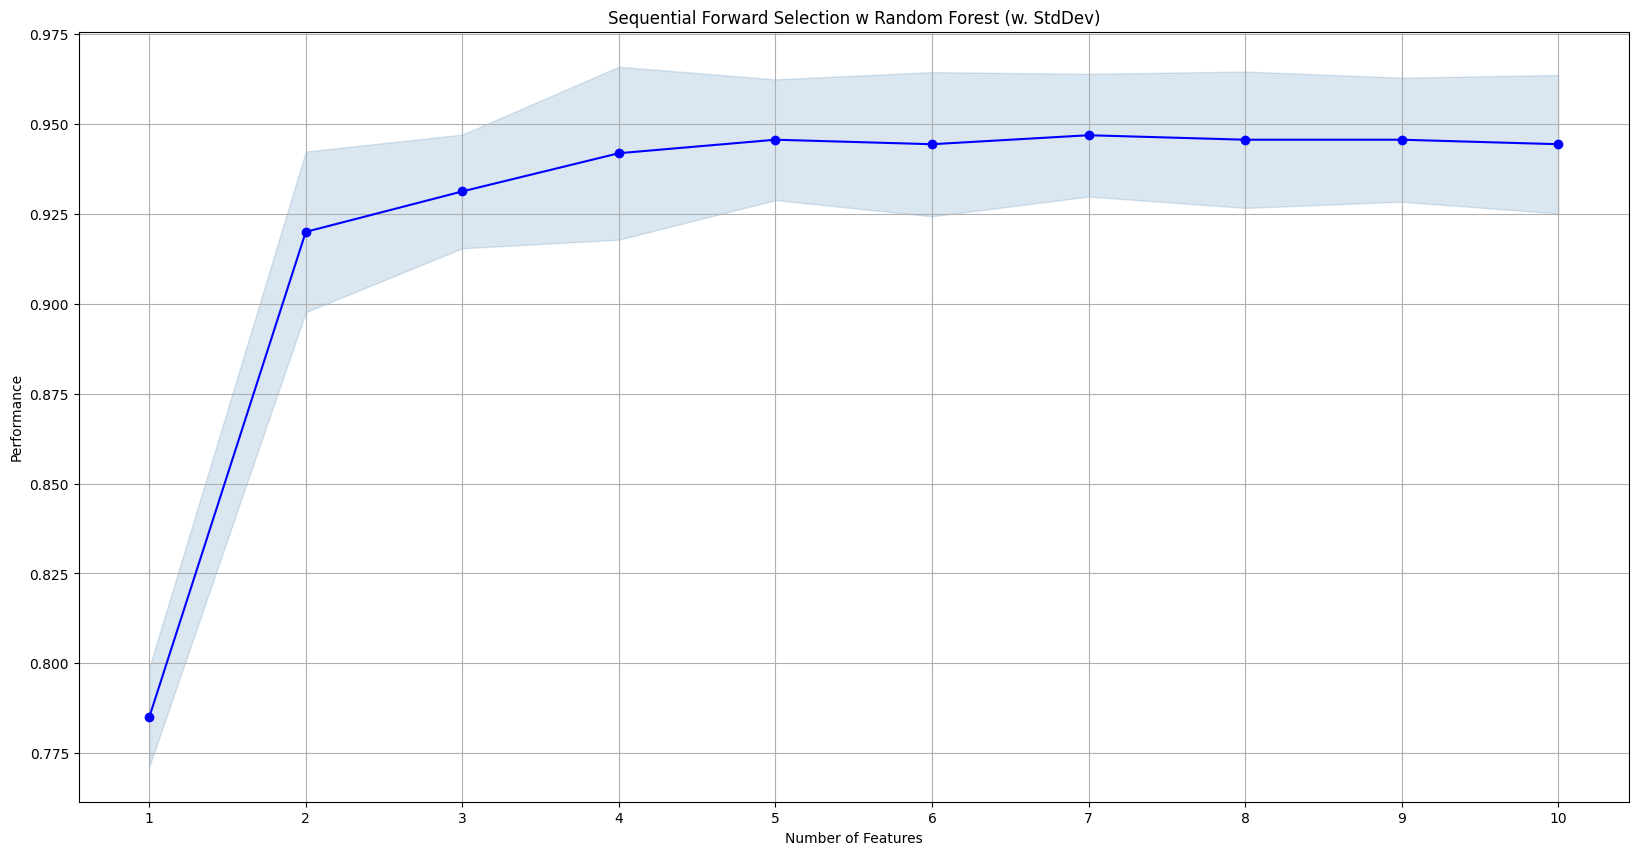

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


fig1 = plot_sfs(metric_dict, kind='std_dev',figsize=(20,10))
plt.title('Sequential Forward Selection w Random Forest (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
X.columns[0:][list(sfs.k_feature_idx_)]

Index(['beh_command_line', 'process_path', 'tree_command_line',
       'tree_process_name', 'command_line', 'regkey_read',
       'directory_enumerated', 'regkey_opened', 'file_created', 'dll_loaded'],
      dtype='object')

In [ ]:
rf_sfs_new_features = X.columns[0:][list(sfs.k_feature_idx_)]

In [ ]:
new_X = X[rf_sfs_new_features]

In [ ]:
new_X

,beh_command_line,process_path,tree_command_line,tree_process_name,command_line,regkey_read,directory_enumerated,regkey_opened,file_created,dll_loaded
0,3,3,3,3,0,11,5,0,0,0
1,2,2,2,2,0,1,0,0,0,0
2,2,2,2,2,0,0,0,0,0,0
3,1,1,1,1,1,66,0,0,1,7
4,2,2,2,2,0,11,0,27,0,6
...,...,...,...,...,...,...,...,...,...,...
1995,2,2,2,2,0,0,0,0,0,3
1996,6,6,3,3,5,31,9,8,1,15
1997,1,1,1,1,0,0,0,0,0,0
1998,2,2,2,2,0,18,0,0,0,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.2, random_state = 42)
# create random forest object
RF2= RandomForestClassifier()

# train the model using the training set
RF2.fit(X_train,y_train)

# predict using the testing set
rf_pred = RF2.predict(X_test)

acc_score = accuracy_score(y_test, rf_pred)
print('Random Forest Accuracy Score:',acc_score*100,'%')

Random Forest Accuracy Score: 96.5 %


In [ ]:
get_prediction_duration(RF2)

### 11) Experiment 2D: Feature Reduction Using Random Forest Feature Importance

Feature Importance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# create random forest object
RF3= RandomForestClassifier()

# train the model using the training set
RF3.fit(X_train,y_train)

# predict using the testing set
rf_pred = RF3.predict(X_test)

In [ ]:
acc_score = accuracy_score(y_test, rf_pred)
print('Random Forest Accuracy Score:',acc_score*100,'%')

Random Forest Accuracy Score: 96.75 %


<Axes: >

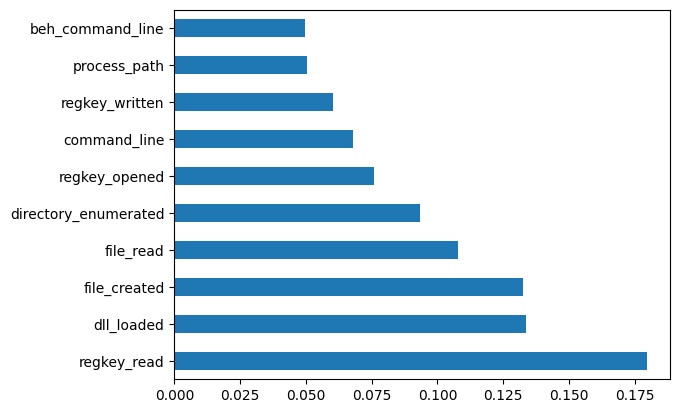

In [ ]:
feat_importances = pd.Series(RF3.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [ ]:
rf_new_features = feat_importances.nlargest(10).index

In [ ]:
rf_new_features

Index(['regkey_read', 'dll_loaded', 'file_created', 'file_read',
       'directory_enumerated', 'regkey_opened', 'command_line',
       'regkey_written', 'process_path', 'beh_command_line'],
      dtype='object')

In [ ]:
new_X = X[rf_new_features]

In [ ]:
new_X

,regkey_read,dll_loaded,file_created,file_read,directory_enumerated,regkey_opened,command_line,regkey_written,process_path,beh_command_line
0,11,0,0,0,5,0,0,0,3,3
1,1,0,0,0,0,0,0,0,2,2
2,0,0,0,0,0,0,0,0,2,2
3,66,7,1,0,0,0,1,0,1,1
4,11,6,0,0,0,27,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...
1995,0,3,0,1,0,0,0,0,2,2
1996,31,15,1,0,9,8,5,1,6,6
1997,0,0,0,0,0,0,0,0,1,1
1998,18,2,0,0,0,0,0,3,2,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.2, random_state = 42)

In [ ]:
# create random forest object
RF2= RandomForestClassifier(n_estimators=4)

# train the model using the training set
RF2.fit(X_train,y_train)

# predict using the testing set
rf_pred = RF2.predict(X_test)

In [ ]:
acc_score = accuracy_score(y_test, rf_pred)
print('Random Forest Accuracy Score:',acc_score*100,'%')

Random Forest Accuracy Score: 96.75 %


In [ ]:
get_prediction_duration(RF2)

Miscellaneous

### 12) Feature Reduction Using Principal Component Analysis

In [ ]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn import decomposition

In [ ]:
pca = decomposition.PCA(0.95)
X_pca = pca.fit_transform(X)
X_pca.shape

(2000, 4)

In [ ]:
# how many components to get 95% variance
pca.n_components_

4

In [ ]:
# obtain variance of each component
pca.explained_variance_ratio_

array([0.70082714, 0.14491858, 0.09151757, 0.03167749])

In [ ]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
# create rf object
rfpca = RandomForestClassifier()

# train the model using the training sets
rfpca.fit(X_train_pca, y_train)

# predict using the testing set
rfpca_pred = rfpca.predict(X_test_pca)

In [ ]:
acc_score = accuracy_score(y_test, rfpca_pred)
print('RF Score:',acc_score*100,'%')

RF Score: 96.25 %


In [ ]:
def train_and_predict_PCA(num_of_components):

  pca = PCA(n_components=num_of_components)
  X_pca = pca.fit_transform(X)
  X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
  # create rf
  rfpca2 = RandomForestClassifier()

  # train the model using the training sets
  rfpca2.fit(X_train_pca, y_train)

  # predict using the testing set
  rfpca_pred2 = rfpca2.predict(X_test_pca)

  acc_score = accuracy_score(y_test, rfpca_pred2)
  print('Num of components: ',num_of_components,'RF Score:',acc_score*100,'%')



In [ ]:
for i in range(1,15):
  train_and_predict_PCA(i)

Num of components:  1 RF Score: 94.25 %
Num of components:  2 RF Score: 96.25 %
Num of components:  3 RF Score: 96.25 %
Num of components:  4 RF Score: 96.5 %
Num of components:  5 RF Score: 96.5 %
Num of components:  6 RF Score: 96.5 %
Num of components:  7 RF Score: 96.5 %
Num of components:  8 RF Score: 96.75 %
Num of components:  9 RF Score: 96.75 %
Num of components:  10 RF Score: 96.75 %
Num of components:  11 RF Score: 96.75 %
Num of components:  12 RF Score: 96.75 %
Num of components:  13 RF Score: 96.75 %
Num of components:  14 RF Score: 96.75 %


In [ ]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
# create rf
rfpca2 = RandomForestClassifier()

# train the model using the training sets
rfpca2.fit(X_train_pca, y_train)

# predict using the testing set
rfpca_pred2 = rfpca2.predict(X_test_pca)

acc_score = accuracy_score(y_test, rfpca_pred2)
print('RF Score:',acc_score*100,'%')


RF Score: 93.75 %


In [ ]:
pca.explained_variance_ratio_

array([0.70082714, 0.14491858, 0.09151757, 0.03167749])

In [ ]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=30)
# create rf object
rfpca3 = RandomForestClassifier(n_estimators=4)

# train the model using the training sets
rfpca3.fit(X_train_pca, y_train)

# predict using the testing set
rfpca_pred3 = rfpca3.predict(X_test_pca)

acc_score = accuracy_score(y_test, rfpca_pred3)
print('RF Score:',acc_score*100,'%')

RF Score: 94.75 %


In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=30)
# create rf object
rfpca4 = RandomForestClassifier(n_estimators=4)

# train the model using the training sets
rfpca4.fit(X_train_pca, y_train)

# predict using the testing set
rfpca_pred4 = rfpca4.predict(X_test_pca)

acc_score = accuracy_score(y_test, rfpca_pred4)
print('RF Score:',acc_score*100,'%')

RF Score: 94.0 %


In [ ]:
pca.explained_variance_ratio_

array([0.70082714, 0.14491858, 0.09151757])

In [ ]:
X = scale(X)

In [ ]:
pca = decomposition.PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

In [ ]:
scores = pca.transform(X)
scores_df = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3'])

In [ ]:
y_list = []

for a in y:
  if a == 'G':
    y_list.append('Goodware')
  elif a == 'L':
    y_list.append('Locker Ransomware')
  else:
    y_list.append('Encryptor Ransomware')

family = pd.DataFrame(y_list, columns=['family'])

In [ ]:
df_scores = pd.concat([scores_df, family], axis=1)

In [ ]:
loadings = pca.components_.T
df_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2','PC3'], index=df.columns.drop('family'))

In [ ]:
explained_variance = pca.explained_variance_ratio_

In [ ]:
import plotly.express as px

explained_variance = np.insert(explained_variance, 0, 0)
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=3))

pc_df = pd.DataFrame(['','PC1', 'PC2', 'PC3'], columns=['PC'])
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])

df_explained_variance = pd.concat([pc_df, explained_variance_df, cumulative_variance_df], axis=1)
df_explained_variance

,PC,Explained Variance,Cumulative Variance
0,,0.000000,0.000
1,PC1,0.305343,0.305
2,PC2,0.091467,0.396
3,PC3,0.084558,0.481


Scree Plot

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_explained_variance['PC'],
        y=df_explained_variance['Cumulative Variance'],
        marker=dict(size=15, color="LightSeaGreen")
    ))

fig.add_trace(
    go.Bar(
        x=df_explained_variance['PC'],
        y=df_explained_variance['Explained Variance'],
        marker=dict(color="RoyalBlue")
    ))

fig.show()

Scores Plot

In [ ]:
import plotly.express as px

fig = px.scatter_3d(df_scores, x='PC1', y='PC2', z='PC3',
              color='family',
              symbol='family',
              opacity=0.5)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))


Loadings Plot

In [ ]:
loadings_label = df_loadings.index
# loadings_label = df_loadings.index.str.strip(' (cm)')

fig = px.scatter_3d(df_loadings, x='PC1', y='PC2', z='PC3',
                    text = loadings_label)

fig.show()
fig.write_html("pcaloadings.html")